# **Análisis de Sistemas Térmicos usando Python**

In [1]:
#pip install Coolprop

In [2]:
#pip install beautifultable

In [3]:
import CoolProp.CoolProp as cp
import numpy as np
import matplotlib.pyplot as plt

## Ejemplo Ciclo Rankine

Consideremos el ciclo Rankine en la Figura, que usa agua como fluido de trabajo.

![Rankine Cycle](rankine_cycle_darkmode.png)

Asumimos que las pérdidas de presión en los intercambiadores de calor son despreciadas.

La turbina y la bomba de alimentación tienen una eficiencia isentrópica constante. 

* $\eta_t$ = 0.9
* $\eta_p$ = 0.75

Además, se establecen la temperatura, presión y flujo de masa de agua a la salida de la caldera y el nivel de presión de condensación.

* Estado 1 : $T_1$ = 600 °C; $P_1$ = 150 bar; $\dot{m}_1$ = 10 kg/s;  
* Estado 2 : $P_2$ = 0.1 bar;

Por último, establecemos la temperatura de alimentación y retorno del agua de enfriamiento, así como su presión de alimentación.

* Estado 11: $T_{11}$ = 20°C; $P_{11}$ = 1.2 bar; 
* Estado 12: $T_{12}$ = 30°C.

Una alternativa es resolver usando Coolprop

In [4]:
# Se selecciona el fluido de trabajo y se inicializan las variables estado
# (Presión, Temperatura, Velocidad, calidad, entalpía)
fluid = "Water"
m_dot = 10 # kg/s
n_estados = 6
P,T,h,s,x = ([np.empty]*n_estados for i in range(5))
Estado = []

eta_t = 0.9
eta_p = 0.75

Determinemos los estados temodinámicos en los diferentes puntos del ciclo (Según la notación en la Figura).

Estado 1: En la entrada de la turbina

In [5]:
Estado.append('Estado 1')
P[0] = 15e6 # Pa
T[0] = 600 + 273.15 # K
h[0] = cp.PropsSI('H', 'P', P[0], 'T', T[0], fluid) # J/kg
s[0] = cp.PropsSI('S', 'P', P[0], 'T', T[0], fluid) # J/kg-K
x[0] = cp.PropsSI('Q', 'P', P[0], 'T', T[0], fluid) # -

Estado 2: En la edescarga de la turbina.

Consideramos eficiencia isentrópica en la turbina.

In [6]:
Estado.append('Estado 2')
P[1] = 10e3 # Pa
h_1_aux = cp.PropsSI('H', 'P', P[1], 'S', s[0], fluid) # J/kg   - Entalpia auxiliar (si la expansion fuera isentrópica)

h[1] = h[0] - eta_t*(h[0] - h_1_aux)        # J/kg - Entalpia real, considerando eficiencia turbina

s[1] = cp.PropsSI('S', 'P', P[1], 'H', h[1], fluid) # J/kg-K
T[1] = cp.PropsSI('T', 'P', P[1], 'H', h[1], fluid) # K
x[1] = cp.PropsSI('Q', 'P', P[1], 'H', h[1], fluid) # [-]

Estado 3: Desacarga del condensador

Se asume que la descarga es líquido saturado.

In [7]:
Estado.append('Estado 3')
P[2] = P[1]
x[2] = 0    # [-] - Líquido saturada
T[2] = cp.PropsSI('T', 'P', P[2], 'Q', x[2], fluid) # K
h[2] = cp.PropsSI('H', 'P', P[2], 'Q', x[2], fluid) # J/kg
s[2] = cp.PropsSI('S', 'P', P[2], 'Q', x[2], fluid) # J/kg-K

Estado 4: Ingreso a la caldera - Generador de vapor

Consideramos eficiencia isentrópica de la bomba

In [8]:
Estado.append('Estado 4')
P[3] = P[0]

h_3_aux = cp.PropsSI('H', 'P', P[3], 'S', s[2], fluid) # J/kg
h[3] = h[2] + (h_3_aux -h[2] )/eta_p # J/kg

T[3] = cp.PropsSI('T', 'P', P[3], 'H', h[3], fluid) # K
s[3] = cp.PropsSI('S', 'P', P[3], 'H', h[3], fluid) # J/kg-K
x[3] = cp.PropsSI('Q', 'P', P[3], 'H', h[3], fluid) # -

Con esto ya tenemos caracterizados todos los estados del ciclo. No obstante, para poder graficarlos es recomendable considerar dos estados auxiliares que ocurren en la caldera.

En la caldera la generación de vapor ocurre a presión constante. Así tendremos un estado de líquido saturado (a la misma presión de entrada) y vapor saturado a la presión equivalente.

Luego, Estado 4.1 - Líquido saturado:

In [9]:
Estado.append('Estado 4_1')
P[4] = P[0]
x[4] = 0
T[4] = cp.PropsSI('T', 'P', P[4], 'Q', x[4], fluid) # K
h[4] = cp.PropsSI('H', 'P', P[4], 'Q', x[4], fluid) # J/kg
s[4] = cp.PropsSI('S', 'P', P[4], 'Q', x[4], fluid) # J/kg-K

Estado 4.2 - Vapor saturado:

In [10]:
Estado.append('Estado 4_2')
P[5] = P[0]
x[5] = 1
T[5] = cp.PropsSI('T', 'P', P[5], 'Q', x[5], fluid) # K
h[5] = cp.PropsSI('H', 'P', P[5], 'Q', x[5], fluid) # J/kg
s[5] = cp.PropsSI('S', 'P', P[5], 'Q', x[5], fluid) # J/kg-K

Importamos la librería beautifulTable para mostrar los estados

In [11]:
from beautifultable import BeautifulTable as bt

In [12]:
print('Estados termodinámicos')
table = bt()
table = bt(maxwidth=100)
table.columns.append([j//1e3 for j in P], header="Presión\n[kPa]")
table.columns.append([j-273.15 for j in T], header="Temperatura\n[C]")
table.columns.append(x, header="Calidad \n[-]")
table.columns.append([j//1e3 for j in h], header="Entalpía\n[kJ/kg]")
table.columns.append([j//1e3 for j in s], header="Entropía\n[kJ/kg K]")

table.rows.header = Estado
print(table)

Estados termodinámicos
+------------+---------+-------------+----------+----------+-----------+
|            | Presión | Temperatura | Calidad  | Entalpía | Entropía  |
|            |  [kPa]  |     [C]     |   [-]    | [kJ/kg]  | [kJ/kg K] |
+------------+---------+-------------+----------+----------+-----------+
|  Estado 1  | 15000.0 |    600.0    |   -1.0   |  3583.0  |    6.0    |
+------------+---------+-------------+----------+----------+-----------+
|  Estado 2  |  10.0   |   45.806    |  0.865   |  2262.0  |    7.0    |
+------------+---------+-------------+----------+----------+-----------+
|  Estado 3  |  10.0   |   45.806    |    0     |  191.0   |    0.0    |
+------------+---------+-------------+----------+----------+-----------+
|  Estado 4  | 15000.0 |   47.518    |   -1.0   |  211.0   |    0.0    |
+------------+---------+-------------+----------+----------+-----------+
| Estado 4_1 | 15000.0 |   342.155   |    0     |  1610.0  |    3.0    |
+------------+---------+----

Y usamos la función PropertyPlot de Coolprop para graficar los estados termodinámicos.

c:\Users\jmcar\anaconda3\envs\Thermodynamics\lib\site-packages\CoolProp\Plots\Common.py:608: UserWarning: Please use "calc_sat_range" to calculate saturation and isoquality lines. Input ranges are discarded.
  warnings.warn(
c:\Users\jmcar\anaconda3\envs\Thermodynamics\lib\site-packages\CoolProp\Plots\Common.py:608: UserWarning: Please use "calc_sat_range" to calculate saturation and isoquality lines. Input ranges are discarded.
  warnings.warn(
c:\Users\jmcar\anaconda3\envs\Thermodynamics\lib\site-packages\CoolProp\Plots\Plots.py:217: UserWarning: Detected an incomplete phase envelope, fixing it numerically.
  warnings.warn("Detected an incomplete phase envelope, fixing it numerically.")


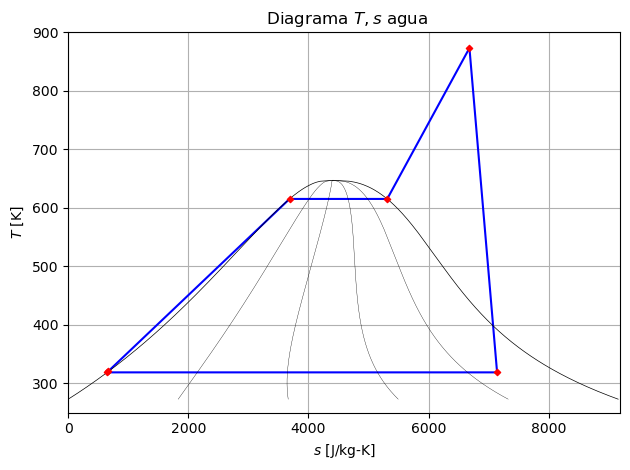

In [13]:
from CoolProp.Plots import PropertyPlot

td_plot = PropertyPlot('Water', 'TS', tp_limits='ORC', unit_system='SI')
td_plot.calc_isolines(cp.iQ, num=6)

ax = plt.gca() # Axis del PropertyPlot
ax.scatter(s,T,c='r',s=10,zorder=3,marker='D') # Puntos con los estado termodinámicos

from matplotlib.lines import Line2D
line = Line2D(s,T,color='b')
ax.add_line(line)
line_close = Line2D([s[0],s[5]],[T[0],T[5]],color='b') # Linea que une los estados inicial y final
ax.add_line(line_close)

ax.set_ylim(250,900) # Modificar los límites 'ORC' en y
td_plot.title(r' Diagrama $T,s$ agua')
td_plot.xlabel(r'$s$ [J/kg-K]')
td_plot.ylabel(r'$T$ [K]')
td_plot.grid()
td_plot.show()









# Alternativa: Biblioteca TESpy

Una alternativa de más alto  ivel es la biblioteca TESpy, la cual tambien usa las propiedades termodinámicas de Coolprop.

TESpy - es un acrónimo de "Thermal Engineering Systems in Python", y que es parte de la plataforma colaborativa: "Open Energy Modeling Framework".

Esta librería posee una serie de módulos que permiten analizar de forma rápida y directa ciclos termodinámicos. Para mayor información puede revisar en este lin la documentación de TESpy:

https://tespy.readthedocs.io/en/master/introduction.html

In [15]:
from tespy.networks import Network

Lo primero que debemos realizar es definir la red de conexiones que constituye el ciclo.

In [16]:
my_plant = Network()
my_plant.set_attr(T_unit='C', p_unit='bar', h_unit='kJ / kg')

A continuación, creamos los componentes y las conexiones. El condensador cuenta con una entrada y salida en el lado caliente, así como una entrada y salida en el lado frío. El lado caliente se indica utilizando el índice 1 para la entrada y salida (in1 y out1), mientras que el lado frío utiliza el índice 2 (in2 y out2).

Para un ciclo termodinámico cerrado, debemos insertar un elemento denominado cerrador de ciclo. La entrada de agua de enfriamiento y la salida de agua de enfriamiento del condensador se conectan directamente a una Fuente y a un Sumidero.

Primero definimos los componentes:

In [17]:
from tespy.components import (
    CycleCloser, Pump, Condenser, Turbine, SimpleHeatExchanger, Source, Sink
)

cc = CycleCloser('cycle closer')
sg = SimpleHeatExchanger('steam generator')
mc = Condenser('main condenser')
tu = Turbine('steam turbine')
fp = Pump('feed pump')

cwso = Source('cooling water source')
cwsi = Sink('cooling water sink')

Luego definimos las conexiones

In [18]:
from tespy.connections import Connection

c1 = Connection(cc, 'out1', tu, 'in1', label='1')
c2 = Connection(tu, 'out1', mc, 'in1', label='2')
c3 = Connection(mc, 'out1', fp, 'in1', label='3')
c4 = Connection(fp, 'out1', sg, 'in1', label='4')
c0 = Connection(sg, 'out1', cc, 'in1', label='0')

my_plant.add_conns(c1, c2, c3, c4, c0)

c11 = Connection(cwso, 'out1', mc, 'in2', label='11')
c12 = Connection(mc, 'out2', cwsi, 'in1', label='12')

my_plant.add_conns(c11, c12)

En cuanto a los parámetros, definimos que no hay pérdida de presión en los intercambiadores de calor (pr=1). En caso de presentar pérdidas, estas se incluyen en en valores entre 0 y 1 (porcentaje).

La turbina y la bomba de alimentación tienen la eficiencia isentrópica ya especificada. Además, se establecen la temperatura, presión y flujo másico del vapor vivo. Por último, fijamos el nivel de presión de condensación y la temperatura de flujo de ida y retorno del agua de enfriamiento, así como su presión de alimentación.

Y con el método solve, resolvemos el ciclo.

In [19]:
mc.set_attr(pr1=1, pr2=1)
sg.set_attr(pr=1)
tu.set_attr(eta_s=0.9)
fp.set_attr(eta_s=0.75)

c11.set_attr(T=20, p=1.2, fluid={'water': 1})
c12.set_attr(T=30)
c1.set_attr(T=600, p=150, m=10, fluid={'water': 1})
c2.set_attr(p=0.1)

my_plant.solve(mode='design')
my_plant.print_results()


 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 2.98e+07   | 0 %        | 3.33e+02   | 2.18e+07   | 4.25e+06   | 0.00e+00   | 0.00e+00   
 2     | 3.46e+06   | 0 %        | 6.19e+01   | 2.70e+06   | 2.24e+06   | 0.00e+00   | 0.00e+00   
 3     | 1.29e+06   | 0 %        | 2.31e+01   | 1.29e+06   | 1.37e+05   | 0.00e+00   | 0.00e+00   
 4     | 5.95e+05   | 2 %        | 2.01e+01   | 5.92e+05   | 1.19e+05   | 0.00e+00   | 0.00e+00   
 5     | 2.48e+05   | 6 %        | 1.74e+01   | 2.44e+05   | 1.03e+05   | 0.00e+00   | 0.00e+00   
 6     | 8.68e+04   | 11 %       | 1.49e+01   | 7.86e+04   | 8.81e+04   | 0.00e+00   | 0.00e+00   
 7     | 3.89e+04   | 15 %       | 1.21e+01   | 2.98e+04   | 7.15e+04   | 0.00e+00   | 0.00e+00   
 8     | 1.36e+04   | 20 %       | 8.54e+00   | 9.92e+03   | 5.06e+04   | 0.00e+00   | 0.00e+00   
 9     | 

# Generación eléctrica como restricción

Una alternativa en el caso de que la información conocida es la generación eléctrica  (y no el flujo másico), en dicho caso activamos la función powergen, y liberamos la restricción de flujo másico. Así, podemos recalcular el ciclo.

In [20]:
from tespy.connections import Bus

powergen = Bus("electrical power output")

powergen.add_comps(
    {"comp": tu, "char": 0.97, "base": "component"},
    {"comp": fp, "char": 0.97, "base": "bus"},
)

my_plant.add_busses(powergen)

my_plant.solve(mode='design')
#my_plant.print_results()


 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 1.11e-05   | 100 %      | 2.87e-10   | 2.60e-23   | 2.16e-07   | 0.00e+00   | 0.00e+00   
 2     | 2.33e-10   | 100 %      | 5.57e-14   | 2.78e-27   | 2.33e-10   | 0.00e+00   | 0.00e+00   
 3     | 3.73e-09   | 100 %      | 3.34e-14   | 5.59e-27   | 2.33e-10   | 0.00e+00   | 0.00e+00   
 4     | 2.33e-10   | 100 %      | 5.57e-14   | 2.78e-27   | 2.33e-10   | 0.00e+00   | 0.00e+00   
Total iterations: 4, Calculation time: 0.02 s, Iterations per second: 199.33


In [21]:
powergen.set_attr(P=-10e6)
c1.set_attr(m=None)

my_plant.solve(mode='design')
my_plant.print_results()


 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 2.61e+06   | 0 %        | 1.02e+02   | 5.30e-12   | 2.20e-07   | 0.00e+00   | 0.00e+00   
 2     | 1.15e-05   | 100 %      | 5.12e-10   | 5.46e-12   | 1.22e-07   | 0.00e+00   | 0.00e+00   
 3     | 1.39e-07   | 100 %      | 6.48e-11   | 1.06e-24   | 1.17e-07   | 0.00e+00   | 0.00e+00   
 4     | 7.27e-09   | 100 %      | 1.85e-12   | 9.24e-26   | 5.56e-09   | 0.00e+00   | 0.00e+00   
Total iterations: 4, Calculation time: 0.05 s, Iterations per second: 78.78

##### RESULTS (SimpleHeatExchanger) #####
+-----------------+----------+----------+----------+-----+-----+------+---------+------+--------+
|                 |        Q |       pr |     zeta |   D |   L |   ks |   ks_HW |   kA |   Tamb |
|-----------------+----------+----------+----------+-----+-----+------+---------+------+--

Por último, podemos realizar un análisis paramétrico de la influencia de las diferentes variables de diseño.

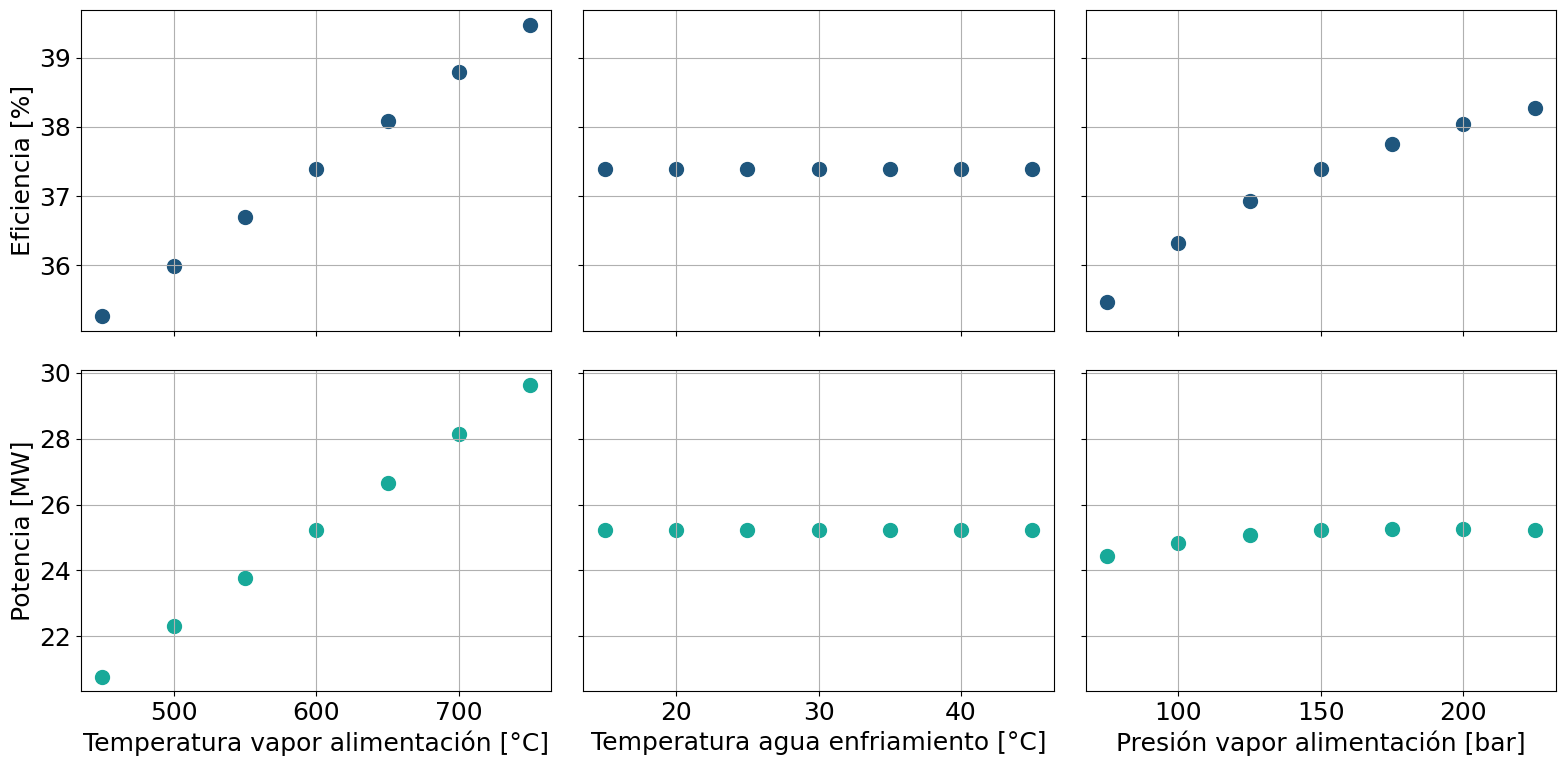

In [22]:
my_plant.set_attr(iterinfo=False)
c1.set_attr(m=20)
powergen.set_attr(P=None)
import matplotlib.pyplot as plt
import numpy as np

# make text reasonably sized
plt.rc('font', **{'size': 18})

data = {
    'T_livesteam': np.linspace(450, 750, 7),
    'T_cooling': np.linspace(15, 45, 7),
    'p_livesteam': np.linspace(75, 225, 7)
}
eta = {
    'T_livesteam': [],
    'T_cooling': [],
    'p_livesteam': []
}
power = {
    'T_livesteam': [],
    'T_cooling': [],
    'p_livesteam': []
}

for T in data['T_livesteam']:
    c1.set_attr(T=T)
    my_plant.solve('design')
    eta['T_livesteam'] += [abs(powergen.P.val) / sg.Q.val * 100]
    power['T_livesteam'] += [abs(powergen.P.val) / 1e6]

# reset to base temperature
c1.set_attr(T=600)

for T in data['T_cooling']:
    c12.set_attr(T=T)
    c11.set_attr(T=T - 10)
    my_plant.solve('design')
    eta['T_cooling'] += [abs(powergen.P.val) / sg.Q.val * 100]
    power['T_cooling'] += [abs(powergen.P.val) / 1e6]

# reset to base temperature
c12.set_attr(T=30)
c11.set_attr(T=20)

for p in data['p_livesteam']:
    c1.set_attr(p=p)
    my_plant.solve('design')
    eta['p_livesteam'] += [abs(powergen.P.val) / sg.Q.val * 100]
    power['p_livesteam'] += [abs(powergen.P.val) / 1e6]

# reset to base pressure
c1.set_attr(p=150)


fig, ax = plt.subplots(2, 3, figsize=(16, 8), sharex='col', sharey='row')

ax = ax.flatten()
[a.grid() for a in ax]

i = 0
for key in data:
    ax[i].scatter(data[key], eta[key], s=100, color="#1f567d")
    ax[i + 3].scatter(data[key], power[key], s=100, color="#18a999")
    i += 1

ax[0].set_ylabel('Eficiencia [%]')
ax[3].set_ylabel('Potencia [MW]')
ax[3].set_xlabel('Temperatura vapor alimentación [°C]')
ax[4].set_xlabel('Temperatura agua enfriamiento [°C]')
ax[5].set_xlabel('Presión vapor alimentación [bar]')
plt.tight_layout()
#fig.savefig('rankine_parametric.svg')
plt.show()